# Analysis of UK road accidents

*I provide an analysis of UK road accidents over the time period 2005-2015. The question of interest is how well some standard classifiers (Logistic Regression, Random Forest, k-Neighbors) can predict whether or not an accident is serious.* 

## Data source

The analysis is based on a data set of approximately 1.7 million road accidents in the United Kingdom between 2005 and 2015. This data set is available on Kaggle:

https://www.kaggle.com/silicon99/dft-accident-data

In the UK, information about road accidents is recorded using a standard form known as “Stats19.” This form can be found online at the relevant government website:

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/230590/stats19.pdf

The Stats19 form records information about the circumstances of each accident, such as day, time, weather conditions, road conditions, and so forth. It also categorizes accidents as either “slight” or “serious” or even “fatal.” Kaggle’s data set contains most (unfortunately not all) of the information collected via the Stats19 form. 

## Preliminaries

Import relevant libraries and functions, and load the dataset. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [2]:
UKroads=pd.read_csv("Accidents0515.csv")

Inspect the dataset and select columns relevant for analysis.

In [3]:
print(UKroads.columns)

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')


In [4]:
column_selection = ["Pedestrian_Crossing-Physical_Facilities", "Number_of_Vehicles", "Number_of_Casualties", "Urban_or_Rural_Area",
          "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions",
          "Road_Type", "Day_of_Week", "Time", "Speed_limit", "Junction_Detail", "Accident_Severity"]

UKroads=UKroads[column_selection]

Check for missing values in the remaining dataset. 

In [5]:
print(UKroads.isnull().sum())

Pedestrian_Crossing-Physical_Facilities      0
Number_of_Vehicles                           0
Number_of_Casualties                         0
Urban_or_Rural_Area                          0
Light_Conditions                             0
Weather_Conditions                           0
Road_Surface_Conditions                      0
Road_Type                                    0
Day_of_Week                                  0
Time                                       151
Speed_limit                                  0
Junction_Detail                              0
Accident_Severity                            0
dtype: int64


It turns out that there are only a few (151 out of more than 1.7 million accidents) rows in which information about time is missing. Given this small number of missing values, it makes sense to simply remove these rows from the dataset, then verify that no more values are missing, and we still have >1.7 million accidents left in the dataset.

In [6]:
UKroads=UKroads.dropna()
print(UKroads.isnull().sum().sum())
print(UKroads.shape)

0
(1780502, 13)


Unfortunately, however, this does not settle the missing values issue. In fact, when filling out the Stats19 form, one can explicitly tick boxes with meanings such as "other" or "unknown". Thus, values may be uninformative or vacuous although they are not technically missing from the dataset. We can identify and eliminate the rows where this is true by looking at the Stats19 form itself. For instance, when it comes to weather information, the Stats19 form assigns the digit 8 to mean "other" and the digit 9 to mean "unknown", hence I remove accidents in which weather conditions are reported as either 8 or 9. Moreover, I also exclude "outlier" accidents where the number of casualties or vehicles involved is greater than 5.  

In [7]:
# Exclude from the dataset those accidents with an unusually high number of casualties or vehicles.
UKroads = UKroads[UKroads["Number_of_Casualties"] <= 5]
UKroads = UKroads[UKroads["Number_of_Vehicles"] <= 5]

# Remove rows where information is missing, vaguely described as "other," or implausible (such as a zero speed limit).
# Simplify information on the time an accident happened: For an accident at hh:mm, we only retain hh. 
UKroads = UKroads[UKroads["Road_Type"] != 9]
UKroads = UKroads[UKroads["Road_Surface_Conditions"] != -1]
UKroads = UKroads[UKroads["Weather_Conditions"]!=8]
UKroads = UKroads[UKroads["Weather_Conditions"]!=9]
UKroads = UKroads[UKroads["Urban_or_Rural_Area"]!=3]
UKroads = UKroads[UKroads["Speed_limit"]!=0]
UKroads = UKroads[UKroads["Junction_Detail"]!=-1]
UKroads = UKroads[UKroads["Urban_or_Rural_Area"]!=3]
UKroads = UKroads[UKroads["Time"].astype("str").str.slice(0,1,1) !="n"]

In [8]:
print(UKroads.shape)

(1688436, 13)


Even after removing all the above cases, there are still 1.688 million accidents left.

A fair amount of the information contained in the data set consists of categorical variables encoded by a set of digits that are not very intuitive. Where appropriate, I decode these variables so that categories have informative names. I also make regroup the categories in order to make only distinctions that seem most relevant: For instance, when categorizing the kind of road on which an accident happened, I consider the slip road as part of an expressway. I also create a distinction between wind information and precipitation information, which the Stats19 form lumps together as weather information.

 For accidents with pedestrians crossing, there is information about the kind of crossing. Group them into
 four categories.

In [9]:
decode_pedestrian = {0:"none", 1:"zebra", 4:"traffic lights", 5:"traffic lights", 7:"other", 8:"other" }
UKroads["Pedestrian_Crossing-Physical_Facilities"]= UKroads["Pedestrian_Crossing-Physical_Facilities"].astype("category").map(decode_pedestrian)

 Weather information on the Stats19 form includes wind conditions, for instance "rain with high winds."
 Create an additional column so as to disentangle information about wind from that about precipitation.

In [10]:

UKroads["Wind_Conditions"] = UKroads["Weather_Conditions"]

decode_weather = { 1:"Fine", 4:"Fine",
                   8:"Other or Unknown", 9:"Other or Unknown",
                   2:"Rain", 5:"Rain",
                   3:"Snow", 6:"Snow",
                   7:"Fog or Mist"
                   }

decode_wind = {1:"No high winds", 2:"No high winds", 3:"No high winds",
               4:"High winds", 5:"High winds", 6:"High winds",
               7:"No high winds", 8:"No high winds", 9:"No high winds"
               }

UKroads["Weather_Conditions"]=UKroads["Weather_Conditions"].astype("category").map(decode_weather)
UKroads["Wind_Conditions"]=UKroads["Wind_Conditions"].astype("category").map(decode_wind)

Simplify information on light conditions to distinguish only between daylight and darkness:

In [11]:
decode_light = {1: "Daylight",
                4:"Dark", 5:"Dark", 6:"Dark", 7:"Dark"
                }

UKroads["Light_Conditions"]=UKroads["Light_Conditions"].astype("category").map(decode_light)

Simplify information on road type: Distinguish between express roads and normal roads. Consider dual carriageways and sliproads as part of express, and others as normal.

In [12]:
decode_road = {1: "normal", 2:"normal", 6:"normal",
               3:"express", 7:"express",
               }
UKroads["Road_Type"]=UKroads["Road_Type"].astype("category").map(decode_road)

Distinguish only between accidents that happen at a roundabout, at some other kind of junction, or outside of any junction.

In [13]:
decode_junction = {0:"no junction", 1: "roundabout", 2: "roundabout", 3:"junction", 5:"junction",
                   6:"junction", 7:"junction", 8:"junction", 9:"junction"}

UKroads["Junction_Detail"] = UKroads["Junction_Detail"].astype("category").map(decode_junction)

Distinguish between accidents that happened in urban vs. rural areas.

In [14]:
decode_area = {1: "urban?", 2:"rural?"}
UKroads["Urban_or_Rural_Area"]=UKroads["Urban_or_Rural_Area"].astype("category").map(decode_area)

 Information about the time of day when accidents happen: Consider only the hour of the accident, that is,
 all accidents between 11:00 and 11:59 are lumped together.

In [15]:

UKroads["Time"]=UKroads["Time"].astype("str").str.slice(0,2,1).astype("int8")

## Accident severity: Slight or serious

As mentioned before, the goal is to figure out how well some standard classifiers can predict how serious an accident is. 

The data set groups accidents into three levels of severity: “slight,” “serious,”  and   “fatal.” 
One challenge is a clear class imbalance with regard to accident severity.
Let us first visualize the share of accidents with the various degrees of severity.

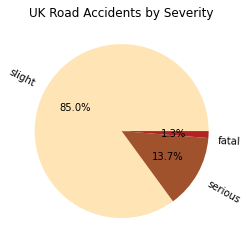

In [16]:
plt.pie(UKroads["Accident_Severity"].value_counts(),
        labels=["slight", "serious", "fatal"],
        autopct='%1.1f%%', shadow=False, startangle=0,
        rotatelabels=True,
        colors=["moccasin","sienna","firebrick"])
plt.title("UK Road Accidents by Severity")
plt.show()

In this analysis, a distinction will be made only between “slight” and “serious” accidents, with the “fatal” accidents included in the “serious” category. There are approximately six slight accidents for each serious accident. 

In [17]:
decode_severity = {3:"slight",
                   1:"serious", 2:"serious",
                   }
UKroads["Accident_Severity"]=UKroads["Accident_Severity"].astype("category").map(decode_severity)

## Frequency vs severity of accidents

Before addressing classification in detail, let us explore the accident data. In particular, we will see the connection between frequency and severity of accidents. 

### Accidents throughout the day

One variable that obviously influences the frequency of road accidents it the time of the day. It is intuitive to expect a lot of accidents during the rush hours, and few accidents at night. It is less clear-cut, however, how the severity of accidents varies over the course of the day. Here is a visualization of serious accidents over the course of the day. The histogram is normalized, so that the fitted line approximates a density function of the distribution of serious accidents throughout the day.

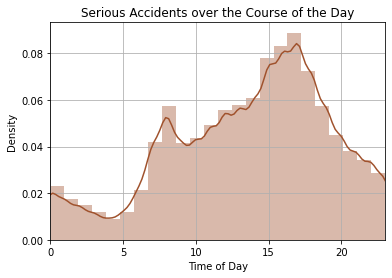

In [18]:
serious_accidents = UKroads[UKroads["Accident_Severity"]=="serious"]
slight_accidents = UKroads[UKroads["Accident_Severity"]=="slight"]

x1 = serious_accidents["Time"]
x2 = slight_accidents["Time"]


sns.distplot(x1, 24, color="sienna")
plt.xlim(0,23)
plt.xlabel("Time of Day")
plt.ylabel("Density")
plt.title("Serious Accidents over the Course of the Day")
plt.grid(True)
plt.show()

As expected, one can see peaks during rush-hours and few serious accidents at night. A less expected observation is that during the daytime off-peak hours, serious accidents tend to become more frequent over time, and the peak in the evening rush hours is much more pronounced than in the morning rush hour.

One question of interest is whether the pattern for serious accidents is different from the pattern for accidents overall. In order to gain insight on this question, I plot the densities of the distribution of serious accidents as well as overall accidents over the course of the day.

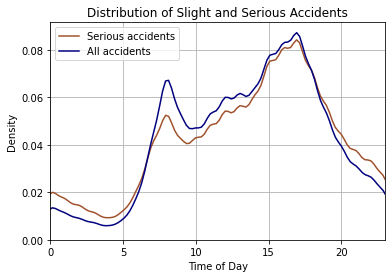

In [19]:
sns.distplot(x1,24,kde=True,hist=False,label="Serious accidents",color="sienna")
sns.distplot(UKroads["Time"],24,kde=True,color="navy",hist=False,label="All accidents",kde_kws={"bw":0.5})
plt.xlabel("Time of Day")
plt.ylabel("Density")
plt.title("Distribution of Slight and Serious Accidents")
plt.legend()
plt.grid()
plt.xlim(0,23)
plt.show()

The brownish graph representing the density of serious accidents is the same as in the previous figure, while the blue graph shows the density of the distribution of accidents overall throughout the day. We see that both distributions follow a similar pattern: Rushhours and off-peak hours are clearly reflected in the graph. However, we also gain an additional insight: The brown line is below the blue one during those hours where there are a lot of accidents. The interpretation is:

*During times of the day when relatively few accidents happen, those accidents which do happen tend to be more serious.*

Let us now visualize how frequency and severity of accidents vary depending on the day of the week. By centering data around its mean, we can construct intuitive measures to answer questions such as: "*How much more frequent are accidents on Friday compared to other days of the week? How much more serious are accidents on Sunday compared to other days of the week?*"

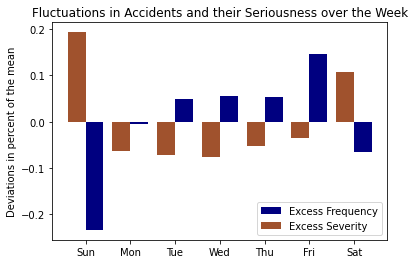

In [20]:
days= ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

vc_total_days = UKroads["Day_of_Week"].value_counts().sort_index()
vc_total_days_mean = vc_total_days.mean()
vc_total_days_centered = (vc_total_days-vc_total_days_mean)/vc_total_days_mean

vc_serious_days = serious_accidents["Day_of_Week"].value_counts().sort_index()
vc_serious_days_mean = vc_serious_days.mean()
vc_serious_days_centered = (vc_serious_days-vc_serious_days_mean)/vc_total_days_centered

share_of_serious = (vc_serious_days/vc_total_days)
share_of_serious_mean =share_of_serious.mean()
share_of_serious_centered = (share_of_serious-share_of_serious_mean)/share_of_serious_mean



new_data = {"Total Accidents":vc_total_days, "Serious Accidents":vc_serious_days,
            "Total Accidents (centered)":vc_total_days_centered,
            "Serious Accidents (centered)":vc_serious_days_centered,
            "Serious Share": share_of_serious_centered}
new_df = pd.DataFrame(new_data)
new_df.index=days


plt.bar([1,2,3,4,5,6,7],new_df["Total Accidents (centered)"],color="navy",tick_label=days,width=0.4,align="edge",
        label="Excess Frequency")
plt.bar([1,2,3,4,5,6,7],new_df["Serious Share"],color="sienna",tick_label=days,width=-0.4,align="edge",
        label="Excess Severity")
#plt.axhline(y=0,xmin=0,xmax=1,color="firebrick",linewidth=2)
plt.legend()
plt.title("Fluctuations in Accidents and their Seriousness over the Week")
plt.ylabel("Deviations in percent of the mean")
plt.show()

In this figure, the bars show the deviation from average values. For instance, the first brown bar indicates how much more likely accidents are to be serious on a Sunday than they are on average – one could call this the “excess severity” of accidents on Sundays. The first blue bar indicates how much less frequent accidents are on Sundays than they are on average – one could describe this by saying that “excess frequency” of accidents is negative on Sundays.  Note that for each of the days of the week (except Monday), the bars point in opposite directions. 

Hence, there is a similar pattern to what we saw when considering the severity of accidents throughout the 24 hours of a day:

*When fewer accidents happen overall, the accidents which do happen are more likely to be serious.*

One channel through which this effect may occur is as follows:
When there is a lot of traffic, a lot of accidents happen, but congestion slows down traffic which makes accidents less serious. 

As a note of caution, observe that the dataset does not really tell us much about the risk of any individual having an accident given that they take the road on any particular day. After all, this would require relating the number of accidents to the amount of road traffic, which is not part of the dataset at hand. 

The dataset contains information on more details of the accident which will be used as features in the classification. Examples are: Information about whether each accident occurred in an urban or rural area. This data shows a similar pattern as the distribution of accidents over days of the week and times of the day: More accidents happen in urban areas, but the share of serious accidents is greater in rural areas. Other examples of features in the dataset are: iformation about the type of road on which the accident happened (single or dual carriageway, crossroads, roundabouts, etc.), information on weather and wind conditions, information on the number of vehicles and casualties involved in each accident.    

## Preparing features for classification

For the purpose of classification, we will lump all weekdays (except Friday) in one category, and the weekends in another. Friday is treated as a category of its own here.

In [21]:
decode_day = {1: "Weekend", 7:"Weekend", 6:"Friday",
             2:"Weekday", 3: "Weekday",  4:"Weekday", 5:"Weekday"}

UKroads["Day_of_Week"]=UKroads["Day_of_Week"].astype("category").map(decode_day)

Some of the features are categorical in nature: Let us deal with them by converting them into dummies. 

In [22]:
# Make a list of the columns for which to create dummies.
dum_cols = ["Pedestrian_Crossing-Physical_Facilities", "Light_Conditions", "Weather_Conditions", "Road_Type",
            "Day_of_Week", "Urban_or_Rural_Area",
            "Wind_Conditions", "Junction_Detail", "Accident_Severity"]

UKroads_dum = pd.get_dummies(UKroads, columns=dum_cols, drop_first=True)

print(UKroads_dum.columns)

Index(['Number_of_Vehicles', 'Number_of_Casualties', 'Road_Surface_Conditions',
       'Time', 'Speed_limit', 'Pedestrian_Crossing-Physical_Facilities_other',
       'Pedestrian_Crossing-Physical_Facilities_traffic lights',
       'Pedestrian_Crossing-Physical_Facilities_zebra',
       'Light_Conditions_Daylight', 'Weather_Conditions_Fog or Mist',
       'Weather_Conditions_Rain', 'Weather_Conditions_Snow',
       'Road_Type_normal', 'Day_of_Week_Weekday', 'Day_of_Week_Weekend',
       'Urban_or_Rural_Area_rural?', 'Wind_Conditions_No high winds',
       'Junction_Detail_no junction', 'Junction_Detail_roundabout',
       'Accident_Severity_slight'],
      dtype='object')


In [23]:
# Now select the features and labels. I exclude information about road surface conditions. This is because
# it will very strongly correlate with weather information (If it rains, then the road is wet.)

X = UKroads_dum.drop(["Road_Surface_Conditions", "Accident_Severity_slight"], axis=1)
y = UKroads_dum["Accident_Severity_slight"]

In [24]:
# Split data into a train and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Classification

The next step is to see how well different kinds of classifiers can distinguish between slight and serious accidents. Three classifiers will be considered: a k-nearest neighbors classifier that predicts the severity of an accident by considering the five accidents most similar to it, a logistic regression classifier, and a random forest classifier.

Each of the three classifiers is adjusted to try and compensate for the class imbalance, although so far, this is done in a very plain way: For the logistic regreesion and the random forest, I use balanced class weights so that the classifier's optimization assigns greater weight to correct classification of serious accidents. For the k-nearest neighbors classifier, I use the weights-parameter to give greater priority to closer neighbors than to more distant neighbors. 

### Running different classifiers

Running the code below **takes time!!**

The results are stored in separate csv files.

In [25]:
#rfc = RandomForestClassifier(class_weight="balanced")
#rfc.fit(X_train, y_train)
#random_forest_predictions = rfc.predict(X_test)

#random_forest_score = rfc.score(X_test, y_test)
#random_forest_confusion_matrix = confusion_matrix(y_test, random_forest_predictions)


#random_forest_confusion_matrix_df = pd.DataFrame(random_forest_confusion_matrix, columns=["Predicted Serious",
#                                                                                          "Predicted Slight"],
#                                                 )
#random_forest_confusion_matrix_df.to_csv("File with RF confusion matrix.csv")

In [26]:
#lr = LogisticRegression(class_weight="balanced", max_iter=1000)
#lr.fit(X_train, y_train)
#lr_predictions = lr.predict(X_test)
#lr_confusion_matrix = confusion_matrix(y_test, lr_predictions)
#lr_dataframe = pd.DataFrame(lr_confusion_matrix)
#lr_dataframe.to_csv("File with Log Regression Results.csv")

In [27]:
#knn = KNeighborsClassifier(weights="distance")
#knn.fit(X_train, y_train)
#knn_predictions = knn.predict(X_test)
#knn_confusion_matrix = confusion_matrix(y_test, knn_predictions)
#knn_confusion_matrix_df = pd.DataFrame(knn_confusion_matrix)
#knn_confusion_matrix_df.to_csv("File with KNN results.csv")

### Performance assessment

Now read in the csv files with the classification results.

In [28]:
Random_Forest = pd.read_csv("File with RF confusion matrix.csv")
Logistic_Regression = pd.read_csv("File with Log Regression Results.csv")
K_Nearest_Neighbors = pd.read_csv("File with KNN results.csv")

Now it is time to check the performance of the three classifiers, using two tools: First, I create confusion matrices that show the number of true positives, true negatives, false positives, and false negatives for each classifier. These matrices are visualized as heatmaps, where the cell corresponding to each category is darker the more accidents belong to it. Below each confusion matrix, some performance metrics are reported: The "naive" accuracy (percentage of accidents correctly classified, regardless of class imbalance), the precision and recall (also in percentage terms), and Cohen's kappa (ranging from 0 to 1).

In [29]:

def heatmap(cm, cmap):
    cm=cm.drop(cm.columns[0], axis=1)
    cm.columns=["Serious", "Slight"]
    cm.index=["Serious", "Slight"]
    heatmap=sns.heatmap(cm, annot=True, annot_kws={"size": 25}, cmap=cmap, cbar=False, fmt="g", linecolor=
                        "black", linewidths=1)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    return heatmap

def performance(cm):
    cm = cm.drop(cm.columns[0], axis=1)
    tp=cm.iloc[0,0]
    fn=cm.iloc[0,1]
    fp=cm.iloc[1,0]
    tn=cm.iloc[1,1]
    naive_accuracy = round((tp+tn)/(tp+tn+fp+fn),4)
    classified_serious_prob=(tp+fp)/(tp+tn+fp+fn)
    precision = round(tp/(tp+fp),4)
    recall = round(tp/(tp+fn),4)
    observed_agreement_prob=(tp+tn)/(tp+tn+fp+fn)
    random_agreement_prob=((tp+fn)*(tp+fp)+(fp+tn)*(fn+tn))/((tp+fp+tn+fn)**2)
    cohens_kappa= (observed_agreement_prob - random_agreement_prob)/(1-random_agreement_prob)  
    print("Naive Accuracy: "+ str(round(observed_agreement_prob*100,1)))
#    print("Share of accidents classified as serious: "+str(round(classified_serious_prob*100,1)))
    print("Precision: "+ str(round(precision*100,1)))
    print("Recall: "+str(round(recall*100,1)))
    print("Cohen's Kappa: "+str(round(cohens_kappa,3)))

    


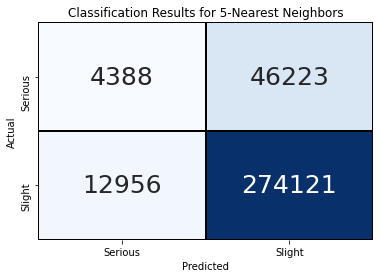

Naive Accuracy: 82.5
Precision: 25.3
Recall: 8.7
Cohen's Kappa: 0.057


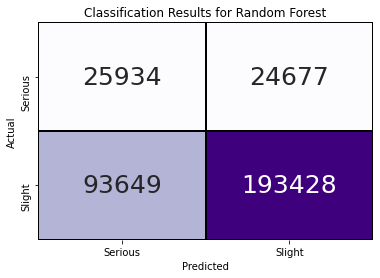

Naive Accuracy: 65.0
Precision: 21.7
Recall: 51.2
Cohen's Kappa: 0.119


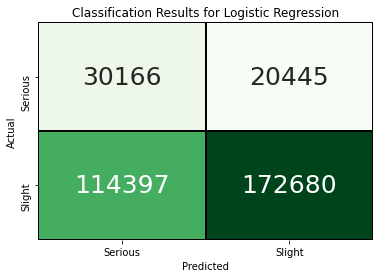

Naive Accuracy: 60.1
Precision: 20.9
Recall: 59.6
Cohen's Kappa: 0.112


In [30]:
heatmap(K_Nearest_Neighbors, "Blues")
plt.title("Classification Results for 5-Nearest Neighbors")
plt.show()
performance(K_Nearest_Neighbors)

heatmap(Random_Forest, "Purples")
plt.title("Classification Results for Random Forest")
plt.show()
performance(Random_Forest)

heatmap(Logistic_Regression, "Greens")
plt.title("Classification Results for Logistic Regression")
plt.show()
performance(Logistic_Regression)


### Interpretation: Which of the classifiers is most appropriate?

In order to address this quesiton, recall the class imbalance in the dataset: About 85% of accidents are slight. Hence, a trivial model which predicts all accidents to be slight would lead to a naive accuracy measure of 85%. However, it is not useful because we presumably do want to identify some serious accidents.

The naive accuracy measure (Which percentage of accidents are classified correctly?) is lower than 85% for all of the three classifiers. Naive accuracy is greatest for the 5-neighbors, smaller for the random forest, and smaller yet for the logistic regression. Conversely, the percentage of accidents classified as serious is greatest for the logistic regression, smaller for the random forest, and smaller still for the 5-neighbors. Since logistic regression classifies a lot of accidents as serious, it is not surprising that it also has the lowest precision and the greatest recall of the three classifiers. The reverse is true for the 5-neighbors.

Imagine that UK authorities wanted to find out how to improve prevention of serious road accidents. In order to start the investigation, they need a classifier which identifies serious accidents. One possibility is that their budget for accident prevention is very limited. Then they might be interested in identifying a small number of accidents which are very likely to be serious. In other words, one would want to choose a classifier with high precision, but not attach too much importance to its recall / sensitivity. In this case, the 5-Nearest Neighbors classifier would be the most attractive.

Alternatively, suppose that the authorities have decided to invest lots of extra resources in accident prevention. They do want to focus on serious accidents, but the objective is to make a huge effort in accident prevention overall. Hence, one would be interested in a classifier that correctly identifies the serious accidents, and it would not matter so much if it lumps a lot of slight accidents into the serious class by mistake. In that case, the Logistic Regression classifier would be most appealing. 

Finally, we could assess the classifiers' performance from a different perspective: Loosely speaking, we could ask how effective the classifier is in using the information contained in our dataset. Consider the random forest classifier. It classifies 35.4% of accidents as serious. Let us imagine a "dumb" benchmark classifier that just randomly classifies each accident as serious with 35.4% probability **without** paying any attention to the features at all. We can then ask by how much our actual random forest classifier does better than that benchmark. The answer to this question is given by the kappa-statistic ("Cohen's kappa"), which equals 0.119 for our random forest. This is the highest kappa for any of the three classifiers considered. In that sense, the random forest is the "best" of the above classifiers.

Unfortunately, however, none of the three classifiers above seems to have a particularly impressive performance. Of course, it is always possible that the features are simply not that informative for predicting accident severity, no matter which classifier one uses. However, there are still plenty of possibilities that could be tried to improve the classification.

For example the following:

### To be done

Instead of working with the class weight parameters, try to deal with class imbalance by undersampling slight accidents.

Try more sophisticated way to deal with class imbalance in the KNN classifier

Try to use a support vector classifier